```{index} disjunctive programming
```
```{index} single: solver; cbc
```
```{index} single: application; maintenance planning
```

# Extra material: Maintenance planning

## Problem statement


A process unit is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the unit makes a profit $c[t]$ which is known in advance. The unit needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Imports

In [ ]:
# install dependencies and select solver
!pip install -q amplpy matplotlib

SOLVER = "cbc"

from amplpy import AMPL, tools

ampl = tools.ampl_notebook(
    modules=["cbc"], # modules to install
    license_uuid="default" # license to use
)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Modeling with disjunctive constraints

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the process unit, with $x_t=1$ indicating the unit is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the unit is not operating and earning $0$ profit.

### Objective

The planning objective is to maximize profit realized during the days the plant is operational. 

$$
\begin{align*}
\mbox{Profit} & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}
$$

subject to completing $P$ maintenance periods.  

### Constraints

**Number of maintenance periods is equal to P.**

Completing $P$ maintenance periods requires a total of $P$ starts.

$$
\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}
$$

**Maintenance periods do not overlap.**

No more than one maintenance period can start in any consecutive set of M days.

$$
\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

This last requirement could be modified if some period of time should occur between maintenance periods.

**The unit must shut down for M days following a maintenance start.**

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. Mathematically, this forms a set of constraints reading

$$
\begin{align*}
\left(y_t = 0\right) \veebar \left(\sum_{s=0}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where $\veebar$ denotes an exclusive or condition.

## AMPL solution

### Parameter values

In [3]:
# problem parameters
T = 90        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
np.random.seed(0)
c = {k: np.random.uniform() for k in range(1, T+1)}

### AMPL model

The disjunctive constraints can be represented directly in AMPL using [Logic, Nonlinear & Constraint Programming Extensions](https://ampl.com/products/ampl/logic-and-constraint-programming-extensions/). The extension transforms the disjunctive constraints to a mixed integer linear optimization (MILO) problem using convex hull and cutting plane methods.

In [4]:
%%writefile maintenance_planning.mod

param T; # number of planning periods
param P; # number of maintenance periods
param M; # number of days for each maintenance period

set PH := 1..T; # set of planning horizon time periods

set Y := 1..(T - M + 1);
set S := 0..(M - 1);

param c{PH}; # profit

var x{PH} binary;
var y{PH} binary;

maximize profit: sum{t in PH} c[t] * x[t];

s.t. required_maintenance: P == sum{t in Y} y[t];
s.t. no_overlap {t in Y}: sum{s in S} y[t + s] <= 1;
s.t. required_shutdown {t in Y}:
    (y[t] == 0 or sum{s in S} x[t + s] == 0)
    and not
    (y[t] == 0 and sum{s in S} x[t + s] == 0);

Writing maintenance_planning.mod


cbc 2.10.7: cbc 2.10.7: optimal solution; objective 41.92584964
21 simplex iterations
21 barrier iterations


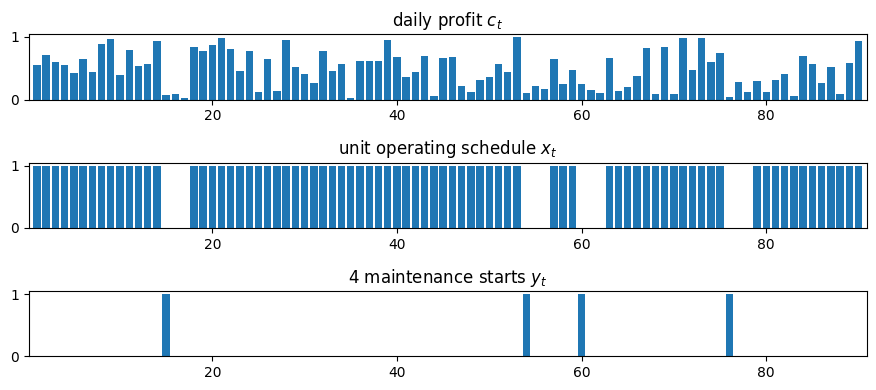

In [5]:
class MP(object):

    def __init__(self, c, M, P):
        
        self.T = len(c)
        self.M = M
        self.P = P
        self.c = c
        
        self.modfile = 'maintenance_planning.mod'
        
        self.ampl = AMPL()
        self.ampl.option['solver'] = SOLVER
        self.solved = False


    def load_data(self):

        self.ampl.param['T'] = self.T
        self.ampl.param['P'] = self.P
        self.ampl.param['M'] = self.M
        self.ampl.param['c'] = self.c

        
    def set_solver(self, solver):
        self.ampl.option['solver'] = solver

        
    def set_modfile(self, modfile):
        self.modfile = modfile

        
    def solve(self):

        self.ampl.read(self.modfile)
        self.load_data()
        self.ampl.solve()
        self.solved = True

        
    def plot_schedule(self):
        
        if not self.solved:
            self.solve()
            
        T = self.T
        M = self.M
        P = self.P
        PH = list(range(1, T + 1))
        Y = list(range(1, T - M + 2))
        S = list(range(M))

        fig,ax = plt.subplots(3, 1, figsize=(9,4))
    
        ax[0].bar(PH, [self.c[t] for t in PH])
        ax[0].set_title('daily profit $c_t$')

        x = self.ampl.var['x'].get_values().to_dict()
        
        ax[1].bar(PH, [x[t] for t in PH], label='normal operation')
        ax[1].set_title('unit operating schedule $x_t$')

        y = self.ampl.var['y'].get_values().to_dict()
        
        ax[2].bar(Y, [y[t] for t in Y])
        ax[2].set_title(str(P) + ' maintenance starts $y_t$')
        for a in ax:
            a.set_xlim(0.1, T+0.9)
        
        plt.tight_layout()
        

model = MP(c, M, P)
model.plot_schedule()

## Ramping constraints

Prior to maintenance shutdown, a large processing unit may take some time to safely ramp down from full production. And then require more time to safely ramp back up to full production following maintenance. To provide for ramp-down and ramp-up periods, we modify the problem formation in the following ways.

* The variable denoting unit operation, $x_t$ is changed from a binary variable to a continuous variable $0 \leq x_t \leq 1$ denoting the fraction of total capacity at which the unit is operating on day $t$.

* Two new variable sequences, $0 \leq u_t^+ \leq u_t^{+,\max}$ and $0\leq u_t^- \leq u_t^{-,\max}$, are introduced which denote the fraction increase or decrease in unit capacity to completed on day $t$.

* An additional sequence of equality constraints is introduced relating $x_t$ to $u_t^+$ and $u_t^-$.

$$
\begin{align*}
x_{t} & = x_{t-1} + u^+_t - u^-_t
\end{align*}
$$

We begin the AMPL model by specifying the constraints, then modifying the Big-M formulation to add the features described above.

In [6]:
%%writefile maintenance_planning_ramp.mod

param T; # number of planning periods
param P; # number of maintenance periods
param M; # number of days for each maintenance period

param upos_max;
param uneg_max;

set PH := 1..T; # set of planning horizon time periods

set Y := 1..(T - M + 1);
set S := 0..(M - 1);

param c{PH}; # profit

var x{PH} >= 0, <= 1;
var y{PH} binary;
var upos{PH} >= 0, <= upos_max;
var uneg{PH} >= 0, <= uneg_max;

maximize profit: sum{t in PH} c[t] * x[t];

s.t. required_maintenance: P == sum{t in Y} y[t];
s.t. no_overlap {t in Y}: sum{s in S} y[t + s] <= 1;
s.t. required_shutdown {t in Y}:
    y[t] == 1 ==> sum{s in S} x[t + s] == 0;
s.t. ramp {t in PH: t != 1}:
    x[t] == x[t-1] + upos[t] - uneg[t];

Writing maintenance_planning_ramp.mod


cbc 2.10.7: cbc 2.10.7: optimal solution; objective 39.53508979
4839 simplex iterations
4839 barrier iterations
12 branching nodes


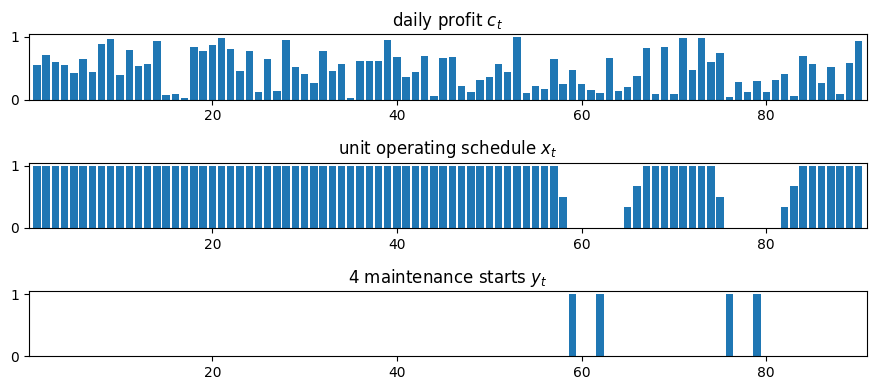

In [7]:
class MPRamp(MP):

    def __init__(self, c, M, P, upos_max, uneg_max):

        super(MPRamp, self).__init__(c, M, P)
        super(MPRamp, self).set_modfile('maintenance_planning_ramp.mod')        
        self.upos_max = upos_max
        self.uneg_max = uneg_max
        

    def load_data(self):

        super(MPRamp, self).load_data()        
        self.ampl.param['upos_max'] = self.upos_max
        self.ampl.param['uneg_max'] = self.uneg_max


upos_max = 0.3334
uneg_max = 0.5000

model = MPRamp(c, M, P, upos_max, uneg_max)
model.plot_schedule()

## Specifying the minimum number of operational days between maintenance periods

Up to this point we have imposed no constraints on the frequency of maintenance periods. Without such constraints, particularly when ramping constraints are imposed, is that maintenance periods will be scheduled back-to-back, which is clearly not a useful result for most situations.

The next revision of the model is to incorporate a requirement that $N$ operational days be scheduled between any maintenance periods. This does allow for maintenance to be postponed until the very end of the planning period. The disjunctive constraints read

$$
\begin{align*}
\left(y_t = 0\right) \veebar \left(\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where the upper bound on the summation is needed to handle the terminal condition. 

Paradoxically, this is an example where the Big-M method provides a much faster solution.

$$
\begin{align*}
\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} \leq (M+N)(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

The following cell implements both sets of constraints. 

In [8]:
%%writefile maintenance_planning_ramp_operational.mod

param T; # number of planning periods
param P; # number of maintenance periods
param M; # number of days for each maintenance period
param N;

param upos_max;
param uneg_max;

set PH := 1..T; # set of planning horizon time periods

set Y := 1..(T - M + 1);
set S := 0..(M - 1);
set W := 0..(M + N - 1);
    
param c{PH}; # profit

var x{PH} >= 0, <= 1;
var y{PH} binary;
var upos{PH} >= 0, <= upos_max;
var uneg{PH} >= 0, <= uneg_max;

maximize profit: sum{t in PH} c[t] * x[t];

# ramp constraint
s.t. ramp {t in PH: t > 1}:
    x[t] == x[t-1] + upos[t] - uneg[t];
# required number P of maintenance starts
s.t. sumy: P == sum{t in Y} y[t];
# no more than one maintenance start in the period of length M
s.t. sprd {t in Y}:
    sum{s in W: t + s <= T} y[t+s] <= 1;

# Choose one of the following constraints (disj or bigm).
# Comment out the constraint not used.
#s.t. disj {t in Y}:
#    y[t] == 1 ==> sum{s in W: t + s <= T} x[t+s] == 0;

s.t. bigm {t in Y}:
    sum{s in W: t + s <= T} x[t+s] <= (M+N)*(1 - y[t]);

Writing maintenance_planning_ramp_operational.mod


cbc 2.10.7: cbc 2.10.7: optimal solution; objective 26.64390078
90873 simplex iterations
90873 barrier iterations
492 branching nodes


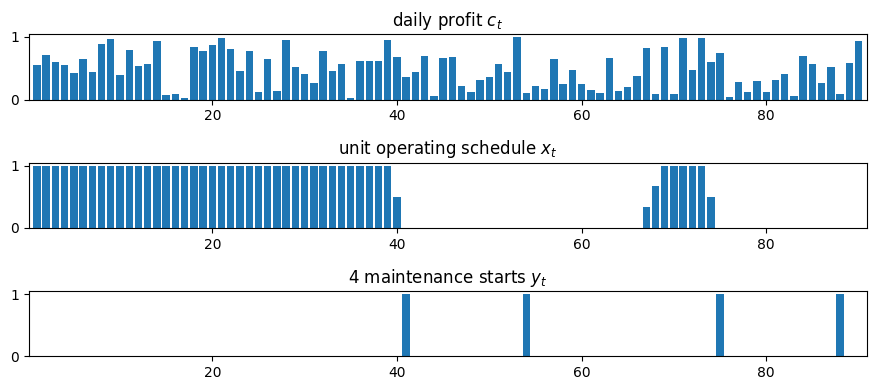

In [9]:
class MPRampOperational(MPRamp):

    def __init__(self, c, M, P, upos_max, uneg_max, N):

        super(MPRampOperational, self).__init__(c, M, P, upos_max, uneg_max)
        super(MPRampOperational, self).set_modfile('maintenance_planning_ramp_operational.mod')
        self.N = N
        
        
    def load_data(self):

        super(MPRampOperational, self).load_data()        
        self.ampl.param['N'] = self.N
        

N = 10  # minimum number of operational days between maintenance periods
model = MPRampOperational(c, M, P, upos_max, uneg_max, N)
model.plot_schedule()

## Exercises

1. Rather than specify how many maintenance periods must be accommodated, modify the model so that the process unit can operate no more than $N$ days without a maintenance shutdown.  (Hint. You may to introduce an additional set of binary variables, $z_t$ to denote the start of an operational period.)

2. Do a systematic comparison of the Big-M, Convex Hull, and Cutting Plane techniques for implementing the disjunctive constraints. Your comparison should include a measure of complexity (such as the number of decision variables and constraints in the resulting transformed problems), computational effort, and the effect of solver (such as HiGHS vs cbc).